This notebook is based on an exercise from Chapter 4 of the book [Deep Learning for Coders with Fastai and PyTorch: AI Applications Without a PhD](https://www.amazon.com/Deep-Learning-Coders-fastai-PyTorch/dp/1492045527). The chapter details the implementation of simple neural network for binary classification, using a subset of the MNIST dataset.

Here we're extending that example to multi-class classification using the complete MNIST dataset. We'll use the same architectures presented in Chapter 4, which, while not state-of-the-art for the complete MNIST classification problem, serve as a valuable learning experience.

For a more accurate approach, see for instance [Beginners guide to MNIST with fast.ai](https://www.kaggle.com/code/christianwallenwein/beginners-guide-to-mnist-with-fast-ai).

In [1]:
#hide
!pip install -Uqq fastai nbdev

from fastai import *
from fastai.vision import *
from fastai.vision.all import *

import torch
import torch.nn.functional as F

We start by downloading and unzipping the full MNIST dataset. The dataset is split in two folders, `training` and `testing`. Under each we have a folder for each digit `0` - `9`

In [2]:
path = untar_data(URLs.MNIST)
Path.BASE_PATH = path
sorted((path/'training').ls())

[Path('training/0'),
 Path('training/1'),
 Path('training/2'),
 Path('training/3'),
 Path('training/4'),
 Path('training/5'),
 Path('training/6'),
 Path('training/7'),
 Path('training/8'),
 Path('training/9')]

We'll create a list of tensors, where each tensor contains the data for all the images for a given digit - each tensor has shape [N,28,28] where N is the number of images for a given digit and each image is a matrix of 28x28 pixels. For that we'll create a couple of auxiliary functions:

`path_to_tensor` returns a tensor with all the images in a given path.

`path_to_tensor_list` returns a list of tensors, one for each directory under `path`. Since we sort the result of `path.ls`, the tensor list will also be sorted, from digit 0 to 9. i.e. the fist list element contains the tensor with all the images of the digit 0, and so on.

In [3]:
def path_to_tensor(path):
    return torch.stack([tensor(Image.open(o)) for o in path.ls()])
    
def path_to_tensor_list(path):
    return list(map(path_to_tensor, sorted(path.ls())))

In [4]:
train_tensors = path_to_tensor_list(path/'training')
test_tensors = path_to_tensor_list(path/'testing')

train_tensors[0].shape, test_tensors[0].shape

(torch.Size([5923, 28, 28]), torch.Size([980, 28, 28]))

<Axes: >

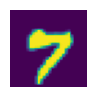

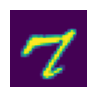

In [5]:
show_image(train_tensors[7][0])
show_image(test_tensors[7][0])

We'll now concatenate all tensors to create a consolidated train and test tensor. We also change the shape - so that each image is given as a sequence of 784 pixels - and we normalize pixel values.

In [6]:
train_x = torch.cat(train_tensors).view(-1, 28*28).float()/255
test_x = torch.cat(test_tensors).view(-1, 28*28).float()/255

train_x.shape, test_x.shape

(torch.Size([60000, 784]), torch.Size([10000, 784]))

<Axes: >

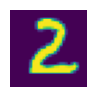

In [7]:
show_image(train_x[13000].view(28,28))

Now let's create the target tensors using one-hot encoding. The target tensor will have 10 columns, one for each class (the digits 0 to 9). For that we'll use the `one_hot`PyTorch function.

As a first step we'll create a list of tuples containing the number of images for each digit.

In [8]:
train_labels = list(enumerate(map(lambda t: t.shape[0], train_tensors)))
train_labels

[(0, 5923),
 (1, 6742),
 (2, 5958),
 (3, 6131),
 (4, 5842),
 (5, 5421),
 (6, 5918),
 (7, 6265),
 (8, 5851),
 (9, 5949)]

`labels_to_target` receives the tuple list and returns the target tensors.

In [9]:
def labels_to_target(labels):
    res = torch.cat([torch.full((size,), label, dtype=torch.long) for label, size in labels])
    res = F.one_hot(res).float()
    return res
    

In [10]:
train_y = labels_to_target(train_labels)

train_y[torch.randperm(len(train_y))[:5]]

tensor([[0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.]])

In [11]:
train_y[13000]

tensor([0., 0., 1., 0., 0., 0., 0., 0., 0., 0.])

Now the same for the test data:

In [12]:
test_labels = list(enumerate(map(lambda t: t.shape[0], test_tensors)))
test_labels

[(0, 980),
 (1, 1135),
 (2, 1032),
 (3, 1010),
 (4, 982),
 (5, 892),
 (6, 958),
 (7, 1028),
 (8, 974),
 (9, 1009)]

In [13]:
test_y = labels_to_target(test_labels)

test_y[torch.randperm(len(test_y))[:5]]

tensor([[0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.]])

We can now create the data sets and loaders. We'll use a splitter to split the train set between taining and validation sets.

In [14]:
dset = list(zip(train_x,train_y))
x,y = dset[0]
x.shape, y

(torch.Size([784]), tensor([1., 0., 0., 0., 0., 0., 0., 0., 0., 0.]))

In [15]:
split = TrainTestSplitter(test_size=0.2, random_state=42)
train_dset_indexes, val_dset_indexes = split(dset)
len(train_dset_indexes), len(val_dset_indexes)

(48000, 12000)

tensor([0., 0., 0., 0., 0., 0., 0., 0., 1., 0.])


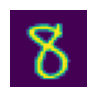

In [16]:
train_dset = [dset[i] for i in train_dset_indexes]
valid_dset = [dset[i] for i in val_dset_indexes]

show_image(train_dset[0][0].view(28,28))
print(train_dset[0][1])

In [17]:
train_dl = DataLoader(train_dset, batch_size=256, shuffle=True)
xb,yb = first(train_dl)
xb.shape,yb.shape

(torch.Size([256, 784]), torch.Size([256, 10]))

In [18]:
valid_dl = DataLoader(valid_dset, batch_size=256, shuffle=True)
xb,yb = first(valid_dl)
xb.shape,yb.shape

(torch.Size([256, 784]), torch.Size([256, 10]))

## SGD

The training loop, based on the code from Chapter 4. One relevant difference is the use of `F.cross_entropy` as the loss function. 

In [19]:
from torch.nn import init
    
def init_lin_params(in_features, out_features, std=1.0): 
    w = (torch.randn((in_features, out_features))*std).requires_grad_()
    b = (torch.randn(out_features)*std).requires_grad_()
    return w, b


# This replicates the Kaiming parameter initialization implemented in nn.Linear

def init_lin_params_k(in_features, out_features):
    w = torch.empty((in_features, out_features)).requires_grad_()
    b = torch.empty(out_features).requires_grad_()
    init.kaiming_uniform_(w.T, a=math.sqrt(5))
    fan_in, _ = init._calculate_fan_in_and_fan_out(w)
    bound = 1 / math.sqrt(fan_in) if fan_in > 0 else 0
    init.uniform_(b, -bound, bound)
    return w, b

def calc_grad(xb, yb, model, lossf):
    preds = model(xb)
    loss = lossf(preds, yb)
    loss.backward()
    
def train_epoch(model, lr, params, lossf):
    for xb,yb in train_dl:
        calc_grad(xb, yb, model, lossf)
        for p in params:
            p.data -= p.grad.data * lr
            p.grad.zero_()
            
def batch_accuracy(xb, yb):
    _, preds = torch.max(xb, dim=1)
    _, target = torch.max(yb, dim=1)
    return torch.tensor(torch.sum(preds == target).item() / len(preds))

def validate_epoch(model):
    accs = [batch_accuracy(model(xb), yb) for xb,yb in valid_dl]
    return round(tensor(accs).mean().item(), 4)

def train(model, params, lossf=F.cross_entropy, epochs=50, lr=1):
    for i in range(epochs):
        train_epoch(model, lr, params, lossf)
        print(validate_epoch(model), end=' ')
        
def test(model):
    acc = batch_accuracy(model(test_x), test_y).item()
    return f"{acc:.2f}%"

## Logistic regression

First let's try to train a simple logistic regression model. Note that we're using the Kaming parameter initialization as we get faster convergence relative to random initialization. Also we're replacing `F.sigmoid` with `F.softmax`. Softmax transforms the output vector so that it can be interpreted as the probability of each class given an input. The cross entropy loss function assumes that the output vector can be interpreted as a probability distribution, so it is appropriate to use with the softmax activation function.

In [20]:
def log_reg(xb): 
    res = xb@w1 + b1
    return F.softmax(res, dim=1)

w1, b1 = init_lin_params_k(28*28,10)

train(log_reg, (w1, b1))

0.882 0.8962 0.9016 0.9046 0.9084 0.9094 0.9111 0.9113 0.9119 0.9138 0.9132 0.9145 0.9144 0.9159 0.9158 0.9157 0.9163 0.9174 0.9163 0.9176 0.9186 0.9177 0.9169 0.9184 0.9197 0.9199 0.9199 0.9195 0.9197 0.9193 0.92 0.9209 0.921 0.9205 0.9212 0.9221 0.9218 0.9215 0.9219 0.9212 0.9218 0.9233 0.9226 0.9234 0.9229 0.9231 0.9223 0.9234 0.9228 0.9225 

Let's check accuracy with the test set:

In [21]:
print(test(log_reg))

0.93%


We usually get above 92% with a simple logistic regression model, not bad! Let's see if we get a better result using a model with two layers.

## Two layer net

In [22]:
def two_layer_net(xb): 
    res = xb@w2 + b2
    res = res.max(tensor(0.0))
    res = res@w3 + b3
    res = F.softmax(res, dim=1)
    return res

w2, b2 = init_lin_params_k(28*28, 32)
w3, b3 = init_lin_params_k(32, 10)

train(two_layer_net, (w2, b2, w3, b3), epochs=50)

0.7454 0.753 0.8297 0.8403 0.8366 0.8494 0.8475 0.8511 0.8506 0.8545 0.8566 0.8572 0.8569 0.8591 0.8601 0.8621 0.8627 0.8639 0.861 0.8639 0.8646 0.8639 0.8653 0.8655 0.866 0.8673 0.8669 0.8676 0.8683 0.8675 0.8686 0.8692 0.8685 0.8696 0.869 0.8697 0.8683 0.8705 0.87 0.8703 0.871 0.8708 0.8713 0.871 0.8709 0.8722 0.8715 0.8721 0.8721 0.8731 

Let's check with the test set.

In [23]:
print(test(two_layer_net))

0.87%


With the two layer model we're getting accuracy above 95%. This is in line with the results obtained here with a similar model: [Multi-class classification with MNIST](https://colab.research.google.com/github/google/eng-edu/blob/main/ml/cc/exercises/multi-class_classification_with_MNIST.ipynb?hl=en#scrollTo=pedD5GhlDC-y).

## Using a Learner / PyTorch Modules

Using a Learner and Pytorch modules we essentially get the same results.

In [24]:
import torch.nn as nn

two_layer_nn = nn.Sequential(
    nn.Linear(28*28, 32),
    nn.ReLU(),
    nn.Linear(32,10),
    nn.Softmax(dim=1)
)

dls = DataLoaders(train_dl, valid_dl)

learn = Learner(dls, two_layer_nn, opt_func=SGD,
                loss_func=F.cross_entropy, metrics=batch_accuracy)

In [25]:
learn.fit(50, 1)

epoch,train_loss,valid_loss,batch_accuracy,time
0,1.679848,1.652141,0.823833,00:00
1,1.635012,1.638454,0.829500,00:00
2,1.627853,1.628680,0.838167,00:00
3,1.625863,1.622512,0.843417,00:01
4,1.621568,1.621622,0.842750,00:01
5,1.612862,1.615918,0.848667,00:01
6,1.614815,1.615398,0.847833,00:01
7,1.609027,1.613006,0.850167,00:01
8,1.605884,1.611413,0.851750,00:01
9,1.603771,1.608826,0.853667,00:01


In [26]:
print(test(two_layer_nn))

0.87%


## References

[Deep Learning for Coders with Fastai and PyTorch - Chapter 4](https://github.com/fastai/fastbook/blob/master/04_mnist_basics.ipynb)

[Multi-class classification with MNIST](https://colab.research.google.com/github/google/eng-edu/blob/main/ml/cc/exercises/multi-class_classification_with_MNIST.ipynb?hl=en#scrollTo=pedD5GhlDC-y)
